In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [19]:
!pip install patchify
!pip install segmentation-models
!pip install keras
!pip install tensorflow
!pip install colab



     ---------------------------------------- 0.0/567.7 kB ? eta -:--:--
     -------------------------------------- 567.7/567.7 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [7 lines of output]
      C:\Users\Allan\.conda\envs\fp1_env\lib\site-packages\setuptools\_distutils\dist.py:261: UserWarning: Unknown distribution option: 'tests_require'
        warnings.warn(msg)
      C:\Users\Allan\.conda\envs\fp1_env\lib\site-packages\setuptools\_distutils\dist.py:261: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      error in colab setup command: 'install_requires' must be a string or list of strings containing valid project/version requirement specifiers; Expected end or semicolon (after version specifier)
          pytz>=2011n
              ~~~~~~^
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the p

In [11]:
pip install -U scikit-learn


  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/11.1 MB 7.4 MB/s eta 0:00:02
   ----------- ---------------------------- 3.1/11.1 MB 8.4 MB/s eta 0:00:01
   ----------------- ---------------------- 5.0/11.1 MB 8.4 MB/s eta 0:00:01
   ----------------------- ---------------- 6.6/11.1 MB 8.4 MB/s eta 0:00:01
   ------------------------------ --------- 8.4/11.1 MB 8.5 MB/s eta 0:00:01
   --------------------------------- ------ 9.2/11.1 MB 7.7 MB/s eta 0:00:01
   -------------------------------------- - 10.7/11.1 MB 7.5 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 7.5 MB/s eta 0:00:00
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)


In [20]:
import os
import cv2
from PIL import Image
import numpy as np
import random
import json
import segmentation_models as sm
from patchify import patchify
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
#PART 2
import tensorflow as tf
from keras.models import Model
from keras.layers import Input,Conv2D,MaxPooling2D, Conv2DTranspose
from keras.layers import concatenate,BatchNormalization,Dropout,Lambda
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [26]:
dire = "DubaiDataset"

In [ ]:
# !unzip /content/drive/MyDrive/Working_Segmentation.zip

In [22]:
!pip install google-colab

from google.colab import drive
drive.mount('/content/drive')

ERROR: Could not find a version that satisfies the requirement google-colab (from versions: none)
ERROR: No matching distribution found for google-colab


ModuleNotFoundError: No module named 'google.colab'

In [23]:
image_patch_size = 256

In [27]:
image_dataset = []
mask_dataset = []
for tile_id in range(1,7):
    for image_id in range(1,20):
        image = cv2.imread(f'{dire}/Tile {tile_id}/images/image_part_00{image_id}.jpg',1)
        mask = cv2.imread(f'{dire}/Tile {tile_id}/masks/image_part_00{image_id}.png',1)

        if image is not None:

            size_x = (image.shape[1]//image_patch_size)*image_patch_size
            size_y = (image.shape[0]//image_patch_size)*image_patch_size

            image = Image.fromarray(image)
            image = image.crop((0,0,size_x,size_y))
            image = np.array(image)
            patched_images = patchify(image,(image_patch_size,image_patch_size,3),step = image_patch_size)

            for i in range(patched_images.shape[0]):
                for j in range(patched_images.shape[1]):
                    individual_image = patched_images[i,j,:,:]

                    individual_image = MinMaxScaler().fit_transform(individual_image.reshape(-1,individual_image.shape[-1])).reshape(individual_image.shape)
                    individual_image = individual_image[0]

                    image_dataset.append(individual_image)

            mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
            mask = Image.fromarray(mask)
            mask = mask.crop((0, 0, size_x, size_y))
            mask = np.array(mask)
            patched_masks = patchify(mask, (image_patch_size, image_patch_size, 3), step=image_patch_size)

            for i in range(patched_masks.shape[0]):
                for j in range(patched_masks.shape[1]):

                    individual_mask = patched_masks[i, j, :, :]
                    #individual_mask = MinMaxScaler().fit_transform(individual_mask.reshape(-1, individual_mask.shape[-1])).reshape(individual_mask.shape)
                    individual_mask = individual_mask[0]

                    mask_dataset.append(individual_mask)



In [28]:
print(len(image_dataset))
print(len(mask_dataset))

441
441


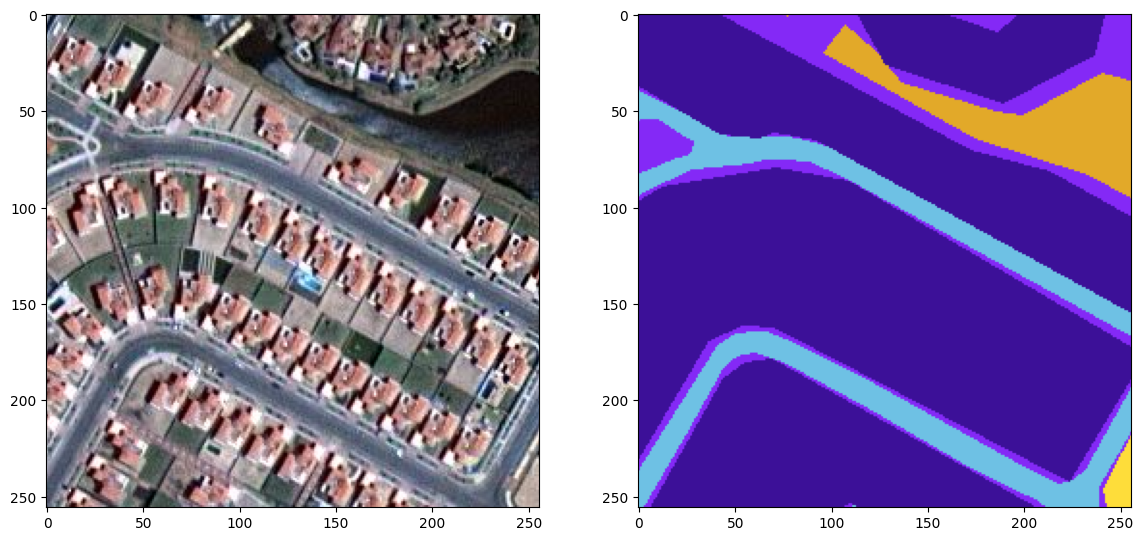

In [29]:
random_image_id = random.randint(0,len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])


In [31]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [32]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [33]:
mask_dataset_np = np.array(mask_dataset)
image_dataset_np = np.array(image_dataset)
labels = []
for i in range(mask_dataset_np.shape[0]):
  label = rgb_to_label(mask_dataset_np[i])
  labels.append(label)

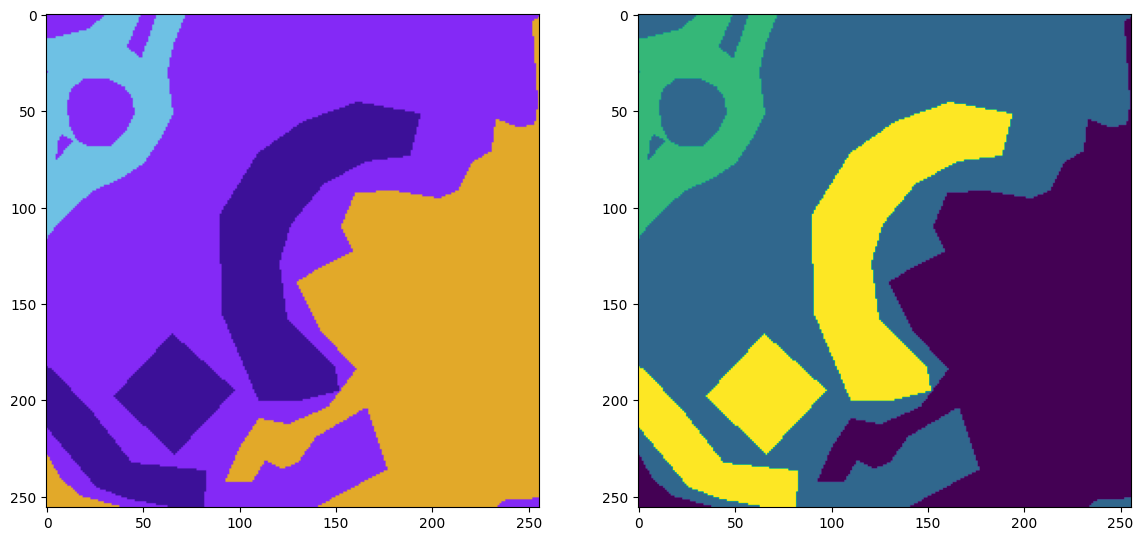

In [34]:
#np.expand_dims(labels,axis=3)

random_image_id = random.randint(0,len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(mask_dataset[random_image_id])
plt.subplot(122)
plt.imshow(labels[random_image_id])


In [35]:
total_classes = 6

In [36]:
#One hot encoded dataset
#For each pixel its label is represented as an array ex 3 is [0 0 1 0 0 0]
# 5 is [0 0 0 0 1 0]
labels_catagorical_dataset = to_categorical(labels,num_classes = total_classes)

In [37]:
X_train,X_test ,y_train,y_test = train_test_split(image_dataset_np,labels_catagorical_dataset,test_size=0.2,random_state=100)

In [38]:
def jaccard_coef(y_true,y_pred):
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_flat*y_pred_flat)
    final_coef_value = (intersection +1.0)/(tf.keras.backend.sum(y_true_flat)+tf.keras.backend.sum(y_pred_flat)-intersection+1.0)
    return final_coef_value

In [39]:
def multi_Unet_model(num_classes,image_height=256,image_width=256,image_channels=3):
    inputs  = Input((image_height,image_width,image_channels))

    source_inputs = inputs

    c1 = Conv2D(filters = 16,kernel_size = (3,3),activation="relu",kernel_initializer="he_normal",padding="same")(source_inputs)
    c1 = Dropout(rate=0.2)(c1) #Dropout 20% of the data from c1
    c1 = Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p1)
    c2 = Dropout(rate=0.2)(c2) #Dropout 20% of the data from c1
    c2 = Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p2)
    c3 = Dropout(rate=0.2)(c3) #Dropout 20% of the data from c1
    c3 = Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p3)
    c4 = Dropout(rate=0.2)(c4) #Dropout 20% of the data from c1
    c4 = Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p4)
    c5 = Dropout(rate=0.2)(c5) #Dropout 20% of the data from c1
    c5 = Conv2D(256,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c5)

    u6 = Conv2DTranspose(128,(2,2),strides=(2,2),padding="same")(c5)
    u6 = concatenate([u6,c4])
    c6 = Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c6)

    u7 = Conv2DTranspose(64,(2,2),strides=(2,2),padding="same")(c6)
    u7 = concatenate([u7,c3])
    c7 = Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c7)


    u8 = Conv2DTranspose(32,(2,2),strides=(2,2),padding="same")(c7)
    u8 = concatenate([u8,c2])
    c8 = Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c8)

    u9 = Conv2DTranspose(16,(2,2),strides=(2,2),padding="same")(c8)
    u9 = concatenate([u9,c1],axis=3)#NOTE axis changed
    c9 = Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c9)

    outputs = Conv2D(num_classes,(1,1),activation="softmax")(c9)
    model = Model(inputs =[inputs],outputs=[outputs])

    return model

In [40]:
metrics = ["accuracy",jaccard_coef]
model = multi_Unet_model(total_classes,256,256,3)

In [ ]:
# model.get_config()

In [41]:
#Loss function (Focal loss)(Cross entropy loss)
wieghts = [0.166,0.166,0.166,0.166,0.166,0.166]
dice_loss = sm.losses.DiceLoss(class_weights=wieghts)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1*focal_loss)

In [42]:
tf.keras.backend.clear_session()
model.compile(optimizer="adam",loss=total_loss,metrics=metrics)

In [ ]:
# model.summary()

In [43]:
model_history = model.fit(X_train,y_train,batch_size=16,verbose=1,epochs=25,validation_data=(X_test,y_test),shuffle=False)


Epoch 1/25


c:\Users\Allan\.conda\envs\fp1_env\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(16, 256, 256, 3))
  warnings.warn(msg)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2517 - jaccard_coef: 0.1236 - loss: 1.0236

c:\Users\Allan\.conda\envs\fp1_env\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2566 - jaccard_coef: 0.1251 - loss: 1.0232 - val_accuracy: 0.4719 - val_jaccard_coef: 0.1758 - val_loss: 1.0082
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4524 - jaccard_coef: 0.1869 - loss: 1.0080 - val_accuracy: 0.6428 - val_jaccard_coef: 0.2141 - val_loss: 0.9992
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6048 - jaccard_coef: 0.2748 - loss: 0.9903 - val_accuracy: 0.6362 - val_jaccard_coef: 0.3930 - val_loss: 0.9780
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6369 - jaccard_coef: 0.3701 - loss: 0.9756 - val_accuracy: 0.6597 - val_jaccard_coef: 0.3982 - val_loss: 0.9714
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6567 - jaccard_coef: 0.3934 - loss: 0.9697 - val_accuracy: 0.6650 - val_jaccard_coef: 0.4028 - val_loss: 0.9690
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6661 - jaccard_coef: 0.4055 - loss: 0.9664 - val_accuracy: 0.6704 -

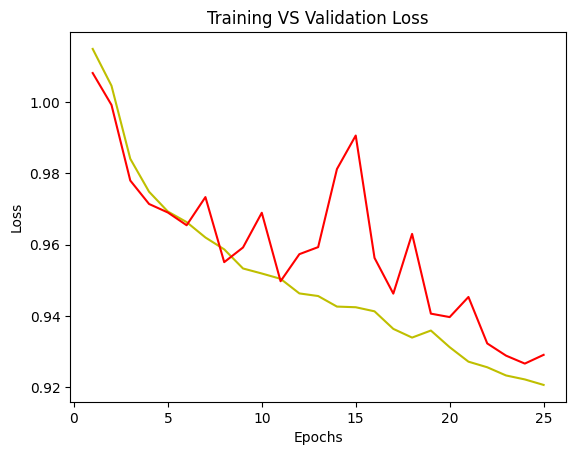

In [44]:
history_a = model_history

loss = history_a.history['loss']
var_loss = history_a.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'y',label="Training Loss")
plt.plot(epochs,var_loss,'r',label="Validation Loss")
plt.title("Training VS Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

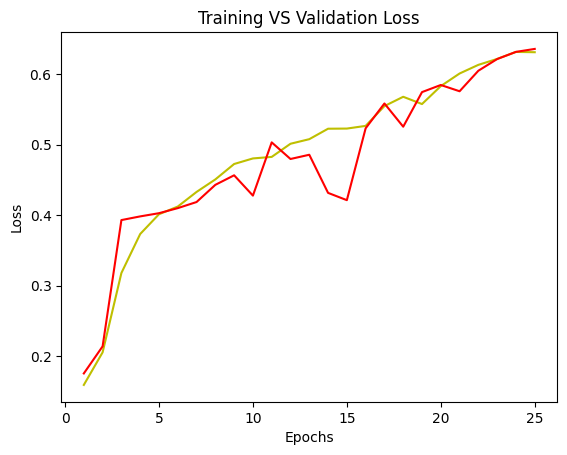

In [45]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']
epochs = range(1,len(jaccard_coef)+1)

plt.plot(epochs,jaccard_coef,'y',label="Training IoU")
plt.plot(epochs,val_jaccard_coef,'r',label="Validation IoU")
plt.title("Training VS Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [46]:
y_pred = model.predict(X_test)

c:\Users\Allan\.conda\envs\fp1_env\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 256, 256, 3))
  warnings.warn(msg)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 610ms/step


In [47]:
y_pred_label = np.argmax(y_pred,axis=3)


In [48]:
y_test_argmax = np.argmax(y_test,axis=3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


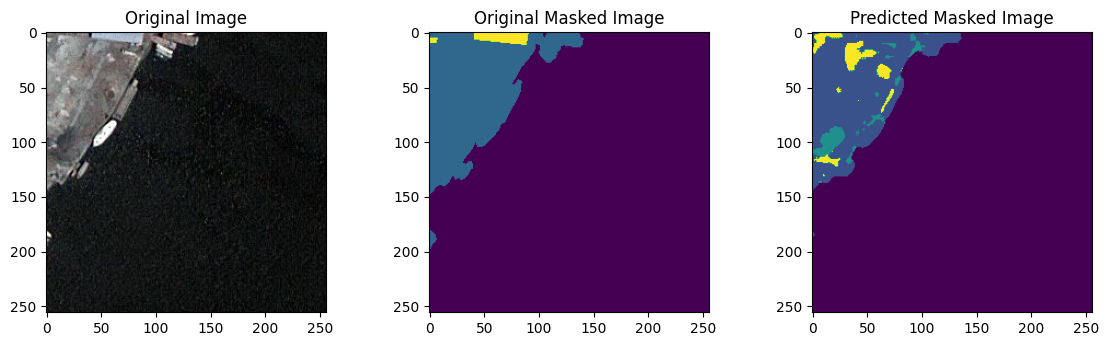

In [49]:
#Comparing Results
test_image_number = random.randint(0,len(y_pred_label))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image,0)
predication = model.predict(test_image_input)
predicted_image = np.argmax(predication,axis=3)

predicted_image = predicted_image[0,:,:]

plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)

plt.subplot(232)
plt.title("Original Masked Image")
plt.imshow(ground_truth_image)

plt.subplot(233)
plt.title("Predicted Masked Image")
plt.imshow(predicted_image)


In [50]:
type(predicted_image)

numpy.ndarray

In [51]:
model.save("Model_satellite_segmentation.h5")

In [52]:
from keras.models import load_model
import os
import cv2
from PIL import Image
import numpy as np
import random
import json
import segmentation_models as sm
from patchify import patchify
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
#PART 2
import tensorflow as tf
from keras.models import Model
from keras.layers import Input,Conv2D,MaxPooling2D, Conv2DTranspose
from keras.layers import concatenate,BatchNormalization,Dropout,Lambda
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


#Loss function (Focal loss)(Cross entropy loss)
wieghts = [0.166,0.166,0.166,0.166,0.166,0.166]
dice_loss = sm.losses.DiceLoss(class_weights=wieghts)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1*focal_loss)

def jaccard_coef(y_true,y_pred):
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_flat*y_pred_flat)
    final_coef_value = (intersection +1.0)/(tf.keras.backend.sum(y_true_flat)+tf.keras.backend.sum(y_pred_flat)-intersection+1.0)
    return final_coef_value



In [54]:
saved_model = load_model('Model_satellite_segmentation.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss,
                                          'jaccard_coef': jaccard_coef}))

In [ ]:
# saved_model.get_config()

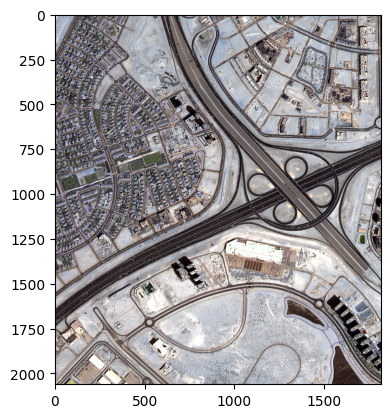

In [63]:
plt.imshow(Image.open('test2.jpg'))

In [64]:
image = Image.open('test2.jpg')
image = image.resize((256,256))
image = np.array(image)
image = np.expand_dims(image, 0)

In [ ]:
# image

In [65]:
prediction = saved_model.predict(image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [66]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

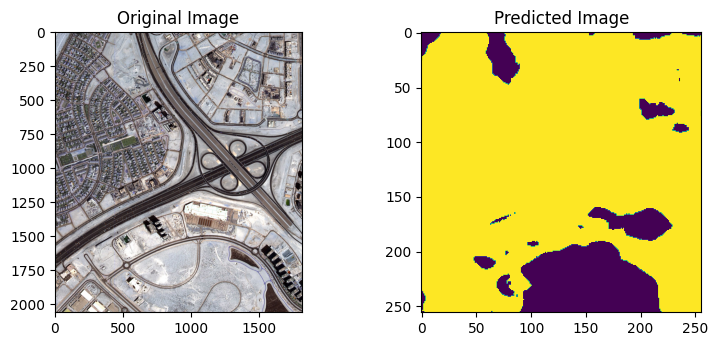

In [67]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('test2.jpg'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)